In [1]:
from Bio import SeqIO
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Conv1D, MaxPooling1D,LSTM, Bidirectional,Dropout
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [2]:
data = pd.read_table('human.txt')
data.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  4380 non-null   object
 1   class     4380 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 68.6+ KB


In [4]:
data['class'].value_counts()

6    1343
4     711
3     672
1     534
0     531
2     349
5     240
Name: class, dtype: int64

In [5]:
data=data[data['sequence'].notnull()]
data=data[data['class'].notnull()]

In [6]:
data.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


In [7]:
count=0
for x in data['sequence']:
    if(len(x)>500):
        count+=1
        
print(count)

2886


In [8]:
data['class'].value_counts()

6    1343
4     711
3     672
1     534
0     531
2     349
5     240
Name: class, dtype: int64

In [9]:
def Kmers_funct(seq, size=6):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]

In [10]:
data['words'] = data.apply(lambda x: Kmers_funct(x['sequence']), axis=1)
data = data.drop('sequence', axis=1)

In [11]:
data.head()

,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."


In [12]:
dna_texts = list(data['words'])
for item in range(len(dna_texts)):
    dna_texts[item] =' '.join(dna_texts[item])

In [13]:
y_data = data.iloc[:, 0].values

In [14]:
y_data

array([4, 4, 3, ..., 6, 6, 6], dtype=int64)

In [15]:
# Pre-processing of DNA sequences using CountVectorizer
vectorizer = CountVectorizer(ngram_range=(4,4),max_features=60000)
X = vectorizer.fit_transform(dna_texts)

In [16]:
X.shape

(4380, 60000)

In [17]:
y_data.shape

(4380,)

In [18]:
y = keras.utils.to_categorical(y_data, num_classes=7)

In [19]:
def create_model(input_shape, num_classes, type='CNN'):
    model = keras.Sequential()
    model.add(keras.layers.Reshape((input_shape[0], 1), input_shape=input_shape))
    
    model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(keras.layers.MaxPooling1D(3, strides=2))
    model.add(keras.layers.Flatten())
    # bidirectional LSTM
    #model.add(Bidirectional(LSTM(100)))

    # LSTM and droput
    
    #model.add(Dropout(0.2))
    #model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [20]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Convert sparse matrix to dense matrix
X_train = X_train.toarray()
X_test = X_test.toarray()

# Reshape the input to add the sequence length dimension
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [22]:
model = create_model(X_train.shape[1:], 7)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 60000, 1)          0         
                                                                 
 conv1d (Conv1D)             (None, 59999, 64)         192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 29999, 64)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1919936)           0         
                                                                 
 dense (Dense)               (None, 64)                122875968 
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                        

In [24]:
history=model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
110/110 [==============================] - 211s 2s/step - loss: 0.9318 - accuracy: 0.7189 - val_loss: 0.4072 - val_accuracy: 0.8733
Epoch 2/10
110/110 [==============================] - 300s 3s/step - loss: 0.1157 - accuracy: 0.9743 - val_loss: 0.3347 - val_accuracy: 0.9224
Epoch 3/10
110/110 [==============================] - 272s 2s/step - loss: 0.0404 - accuracy: 0.9940 - val_loss: 0.2254 - val_accuracy: 0.9384
Epoch 4/10
110/110 [==============================] - 193s 2s/step - loss: 0.0081 - accuracy: 0.9986 - val_loss: 0.2401 - val_accuracy: 0.9395
Epoch 5/10
110/110 [==============================] - 192s 2s/step - loss: 0.0064 - accuracy: 0.9980 - val_loss: 0.2242 - val_accuracy: 0.9475
Epoch 6/10
110/110 [==============================] - 192s 2s/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.4021 - val_accuracy: 0.9144
Epoch 7/10
110/110 [==============================] - 192s 2s/step - loss: 0.0136 - accuracy: 0.9963 - val_loss: 0.2379 - val_accuracy: 0.9498

In [25]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

28/28 [==============================] - 12s 329ms/step - loss: 0.2509 - accuracy: 0.9429
Test Loss: 0.2509157359600067
Test Accuracy: 0.9429223537445068


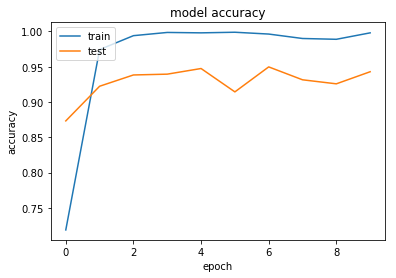

In [26]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

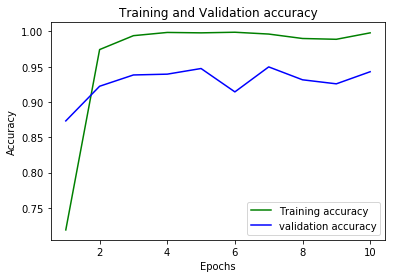

In [27]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
y_pred=model.predict(X_test)

28/28 [==============================] - 9s 332ms/step


28/28 [==============================] - 9s 330ms/step


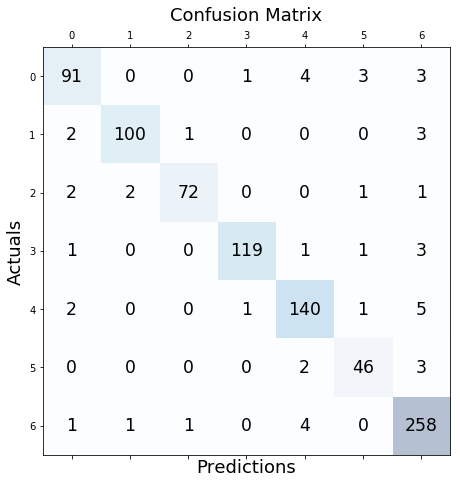

In [29]:
# Get the predictions
#
y_pred = model.predict(X_test)
#
# Calculate the confusion matrix
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [30]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted   0    1   2    3    4   5    6
Actual                                   
0          91    0   0    1    4   3    3
1           2  100   1    0    0   0    3
2           2    2  72    0    0   1    1
3           1    0   0  119    1   1    3
4           2    0   0    1  140   1    5
5           0    0   0    0    2  46    3
6           1    1   1    0    4   0  258
accuracy = 0.943 
precision = 0.943 
recall = 0.943 
f1 = 0.943


In [9]:
# convert the sequences into k-mers of length 4
def convert_to_kmers(sequence, k):
    kmer_list = []
    for i in range(len(sequence) - k + 1):
        kmer_list.append(sequence[i:i+k])
    return " ".join(kmer_list)

In [10]:
data['kmer_sequence'] = data['sequence'].apply(lambda x: convert_to_kmers(x, 4))

In [11]:
X=data['kmer_sequence']

In [12]:
#cv = CountVectorizer(ngram_range=(4,4))
#X = cv.fit_transform(X).toarray()

In [13]:
#X.shape

In [14]:
# split the data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(X, data['class'], test_size=0.2, random_state=42)

In [15]:
# tokenize the k-mer sequences
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(train_data)
train_data = tokenizer.texts_to_sequences(train_data)
test_data = tokenizer.texts_to_sequences(test_data)

In [16]:
# pad the sequences so that they all have the same length
max_length = max([len(x) for x in train_data + test_data])
train_data = pad_sequences(train_data, maxlen=max_length, padding='post')
test_data = pad_sequences(test_data, maxlen=max_length, padding='post')

In [17]:
len(tokenizer.word_index)

6

In [19]:
train_labels.tonumpy()

AttributeError: 'Series' object has no attribute 'tonumpy'

In [20]:
train_labels.unique()

array([6, 4, 0, 2, 1, 5, 3], dtype=int64)

In [19]:
#train_labels = to_categorical(train_labels, num_classes=7)

In [20]:
#test_labels = to_categorical(test_labels, num_classes=7)

In [21]:
# initialize the model
model = Sequential()

In [22]:
# add an embedding layer
model.add(Embedding(len(tokenizer.word_index) + 1, 8, input_length=max_length))

In [23]:
# add a 1D convolutional layer
model.add(Conv1D(128, 3, activation='relu'))

In [24]:
# add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

In [25]:
# add a 1D convolutional layer
model.add(Conv1D(64, 5, activation='relu'))

In [26]:
# add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

In [27]:
#model.add(LSTM(64))

In [28]:
#model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2))

In [29]:
# add a flatten layer
model.add(Flatten())

In [30]:
model.add(Dense(128, activation='relu'))

In [31]:
model.add(Dense(64, activation='relu'))

In [32]:
# add a dense layer with softmax activation function
model.add(Dense(7, activation='softmax'))

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 94589, 8)          56        
                                                                 
 conv1d (Conv1D)             (None, 94587, 128)        3200      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 47293, 128)       0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 47289, 64)         41024     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 23644, 64)        0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 1513216)           0

In [34]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
# train the model on the training data
model.fit(train_data, train_labels, epochs=10, batch_size=64)

Epoch 1/10


ValueError: in user code:

    File "C:\Users\Administrator\anaconda3\envs\pytorchenv\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Administrator\anaconda3\envs\pytorchenv\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Administrator\anaconda3\envs\pytorchenv\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Administrator\anaconda3\envs\pytorchenv\lib\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Administrator\anaconda3\envs\pytorchenv\lib\site-packages\keras\engine\training.py", line 1083, in compute_loss
        y, y_pred, sample_weight, regularization_losses=self.losses
    File "C:\Users\Administrator\anaconda3\envs\pytorchenv\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Administrator\anaconda3\envs\pytorchenv\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Administrator\anaconda3\envs\pytorchenv\lib\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Administrator\anaconda3\envs\pytorchenv\lib\site-packages\keras\losses.py", line 2005, in categorical_crossentropy
        y_true, y_pred, from_logits=from_logits, axis=axis
    File "C:\Users\Administrator\anaconda3\envs\pytorchenv\lib\site-packages\keras\backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 7) are incompatible
